# SWIFT notebook

You can find very detailed SWIFT documentation from this [link](http://swift.dur.ac.uk/docs/index.html). This notebook is only a very basic guide and should not be fully trusted. The choices of modules, compiler, MPI library and parameters is based on my previous test on BlueCrystal 4, BluePebble 1 and Trappist.

## <a name="top"></a>Contents:
[1. Compiling SWIFT](#S1) <br>
 * [Modules](#S11)<br>
 * [Configuration](#S12)<br>
 * [Compilation](#S13)<br>
 * [SLURM scripts](#S14)<br>
 * [Command line options](#S15)<br>

[2. Parameter file](#S2)

[3. Generating IC file](#S3)

[4. 3-D visualization](#S4)

---

## <a name="S1"></a>**1. Compiling SWIFT**

The lastest SWIFT code can be found via [SWIFT github](https://github.com/SWIFTSIM/swiftsim). You should fork this repository to you own github account. Then login to a cluster and `git clone` it:

```{note}
ssh accountNAME@bc4login.acrc.bris.ac.uk
git clone https://github.com/SWIFTSIM/swiftsim.git
```



After downloading SWIFT, using following command to have an intial set up:
```bash

module purge
module load libs/hdf5/1.10.1.MPI
module load libs/gsl/1.16-gcc-9.1.0
module load libs/fftw/3.3.6
module load libtool/2.4.6
module load languages/intel/2020-u4
module load slurm-21.08.8-2

```
To reuse the combination of the modules, save the loaded modules to a name by  
`module save swift_basic`  
The next time when you want to reuse the these modules to compile SWIFT, type   
`module restore swift_basic`

Now `cd` to `swiftsim` directory and start to initialize the code with:   
`./autogen.sh`  

### <a name="S12"></a>**Configuration**

SWIFT can actually compile and run well with the above modules loaded, below are some bonus modules that can further optimize the code and the load balance on muti-core nodes. 
* ParMETIS/METIS (configure option: `--with-parmetis=/path/to/your/locally/installed/parmetis/lib`)
    * BC4 and BP1 have ParMETIS installed but SWIFT can't link to it sometimes, one option is to install the ParMETIS lib locally on your home dir. Download from this [link](http://glaros.dtc.umn.edu/gkhome/metis/parmetis/download) and follow the install instruction. You should first go to the dir `/path/to/lib/parmetis-4.0.3/metis/include/` and edit the file `metis.h`. In the file, change the line 33 from `#define IDXTYPEWIDTH 32` to `#define IDXTYPEWIDTH 64`. After that, at the top of ParMetis' directory execute `make` and follow the instructions. Make sure you provide a installation prefix by using `make config prefix=/some/dir/for/parmetis` . After installation of ParMETIS, please also install METIS using the same installation prefix. Direct to `metis` dir and at the top of Metis' directory execute `make` and follow the instructions. 
* LibNUMA
  * a build of the NUMA library can be used to pin the threads to the physical core of the machine SWIFT is running on. Normally no need to load  any modules on BC4 and PB1, but please use configure option:`--enable-compiler-warnings=yes` during  configuration step, otherwise, it will fail to compile(on bc4 and pb1).
* tcmalloc / jemalloc / TBBmalloc: (configure option:`--with-tcmalloc`, `--with-jemalloc` , `--with-tbbmalloc`)
  * a build of the tcmalloc library, jemalloc or TBBmalloc can be used to obtain faster and more scalable allocations than the standard C malloc function part of glibc. Using one of these is highly recommended on systems with many cores per node. Right now unavaiable on bc4, available on bp1. 

For the planetary simulation, basic configuration is:
```
./configure --with-hydro=planetary --with-equation-of-state=planetary --enable-compiler-warnings=yes \
            --with-gravity=basic --with-numa --with-tbbmalloc  CC=icc  MPICC=mpiicc 


```

To enable entropy forcing, config with:  

```
./configure --with-hydro=planetary --with-equation-of-state=planetary --enable-compiler-warnings=yes \
            --with-gravity=basic --with-numa --with-tbbmalloc  --enable-planetary-fixed-entropy CC=icc MPICC=mpiicc 

```



* SWIFT default compiler is gcc but you can use `CC` environment variable to select the prefered compiler. `./configure CC=icc` to change to use Intel compiler.
* The MPI compiler can be controlled using the `MPICC` variable, much like the `CC` one. 
* copy file `metis.h` from the `/dir/you/intall/parmetis/include` to `/dir/you/intall/swift/swiftsim/src/` would sometimes avoid the compilation error related to ParMETIS library. 
* You will need another SWIFT executable to run artificial cooling (velocity dumping is not included in the SWIFT). During configuration, add this option`--enable-planetary-fixed-entropy` will override the internal energy of each particle each step such that its specific entropy remains constant. Your initial conditions file must includes specific entropies for each particle in order to use this feature.
* add `--with-tbbmalloc` to the above configure command if it's available on your HPC.
* `./configure --help` is pretty helpful, you can find all available options by using that. 

### <a name="S13"></a>**Compilation**

`make -j14` compile the code

After configuration, if everything works fine, your will get a configuartion summary list which you can use to have a double check of the libraries and features you used. \
You can then just use `make` to compile the code. If things go well, you will find two executble `swift` and `swift_mpi` in the `/swiftsim` directory. Run `swift` if you are only using one node. Use `swift_mpi` with one MPI rank per NUMA region (per socket) for muti-node job.

please download the example toolkit using the command below:  
`wget http://www.star.bris.ac.uk/jingyao/workshop/toolkit.tar.gz && tar -xf toolkit.tar.gz && rm toolkit.tar.gz`

---

### <a name="S14"></a>**SLURM scripts** 

Below are some SLURM scripts used on BC4 where each node has two chips with each chip has 14 CPUs(so in total 28 CPUs per node).

#### **<font color='green'>Single-node job with <font color='red'>all</font> cpus</font>**

```
#!/bin/bash -l

#SBATCH -J swift_impact_1node28cpu 
#SBATCH --nodes 1
#SBATCH --cpus-per-task=28
#SBATCH --tasks-per-node=1
#SBATCH --output = out.txt
#SBATCH --error = err.txt
#SBATCH --mail-user=qb20321@bristol.ac.uk
#SBATCH --mail-type=ALL
#SBATCH --time=0-01:00:00
##SBATCH --exclusive


module purge 
module restore swift_basic

./swift -a -s -G -t 28 parameters_impact.yml

```

 #### **<font color='green'>Single-node job with <font color='red'>partial</font> cpus</font>**

```
#!/bin/bash -l

#SBATCH -J swift_impact_1node20cpu 
#SBATCH --nodes 1
#SBATCH --cpus-per-task=20        
#SBATCH --tasks-per-node=1

module purge
module restore swift_basic

./swift -a -s -G -t 20 parameters_impact.yml
```

#### **<font color='green'>Multi-node job with <font color='red'>all</font> cpus</font>**

```
#!/bin/bash -l

#SBATCH -J swift_impact_2node56cpu
#SBATCH --tasks-per-node=2
#SBATCH --nodes 2
#SBATCH --exclusive

module purge
module restore swift_basic

mpirun -np 4 ./swift_mpi -a -s -G -t 14 parameters_impact.yml 

```

#### **<font color='green'>Multi-node job with <font color='red'>partial</font> cpus</font>** 

```
#!/bin/bash -l

#SBATCH -J swift_impact_2node32cpu
#SBATCH --cpus-per-task=8
#SBATCH --tasks-per-node=2
#SBATCH --nodes 2

module purge
module restore swift_baisc

mpirun -np 4 ./swift_mpi -a -s -G -t 8 parameters_impact.yml 
```

### <a name="S15"></a>**Command line options**

* Above script only contains the very basic SLURM skeleton, you can always add other flags to limit the time, memory, partitions, emails, etc. 
* You can check the command line options list by using `./swift -h`. 
* Normally, for the planetary impact simulation, `-s` (stands for running with hydrodynamics) and `-G` (stands for running with self-gravity) are two must have options. 
* `-t <int>` is used to pass on the the number of task threads to use on each MPI rank. If you are running on one node, `-t` can be as large as the total number of threads or cpus the node has. See above "Single-node job with all cpus" script for example. If running with MPI, `-t` can be as large as the number of cpus per chip or socket has. See above "Multi-node job with all cpus" script for example. 
* Typically, HPC clusters now use two chips per node, so in the script, make sure you add `#SBATCH --tasks-per-node=2`, this will let SWIFT run with one MPI rank per NUMA region.
* The `mpirun` comamnd should follow `mpirun -np <number of chips in total> ./swift_mpi -s -G -t <number of cpus(cores) per chip>`. Take BlueCrystal 4 as example: each node has two chips and each chips has 14 cpus, so if using 4 nodes in total ( 8 chips in total then ), it would be like `mpirun -np 8 ./swift_mpi -s -G -t 14`
* Threads pinned. You can do this by passing the `-a` flag to the SWIFT binary. This ensures that processes stay on the same core that spawned them, ensuring that cache is accessed more efficiently.
* Restart. If restart is enabled in the parameters file, you can just restart the job from the most recently generated restart file. Just pass `-r` flag to the SWIFT binary, i.e.,`./swift -r -s -G -t 24`
* Verbose output. Verbose output can be enabled with `-v 1` flag. If runing muti-node job, `-v 2` can be used to output from all ranks. Be careful with the verbose output, logfile can be quit large and will take up all your home directories quota. Better to generate the logfile in the scrath space then.
* Steps. If you want to use number of steps instead simulation time to control the job, pass `-n <int>` to the swift binary. Job will terminate after certain steps. This can be useful when combining with restart to debug.

[Back to Contents](#top)

## <a name="S2"></a>2. Parameter file

```python
# Define the system of units to use internally.
InternalUnitSystem:
    UnitMass_in_cgs:        5.97240e27         # Set the internal mass unit to Earth mass = 5.97240e27 g
    UnitLength_in_cgs:      6.371e8            # Set the internal length unit to Earth radius = 6.371e8 cm
    UnitVelocity_in_cgs:    6.371e8            # Set time in seconds (SWIFT set internal velocity insead of time)
    UnitCurrent_in_cgs:     1.0                # Amperes
    UnitTemp_in_cgs:        1.0                # Kelvin

# Parameters related to the initial conditions
InitialConditions:
    file_name:  ./swift_impact.hdf5      # The initial conditions file to read
    periodic:   0                        # Are we running with periodic ICs?

# Parameters governing the time integration
TimeIntegration:
    time_begin:     0                   # The starting time of the simulation (in internal units).
    time_end:       72000               # The end time of the simulation (in internal units).
    dt_min:         0.0001              # The minimal time-step size of the simulation (in internal units).
    dt_max:         1000                # The maximal time-step size of the simulation (in internal units).

# Parameters governing the snapshots
Snapshots:
    basename:           snapshot        # Common part of the name of output files
    time_first:         0               # Time of the first output (in internal units)
    delta_time:         100             # Time difference between consecutive outputs (in internal units)
    subdir:             ./output        # Output directory, will automatically generate one if not find at the start of the simulation   

# Parameters governing the conserved quantities statistics
Statistics:
    time_first: 0                       # Time of the first output (in internal units)
    delta_time: 1000                    # Time between statistics output

# Parameters controlling restarts
Restarts:
    enable:         1                   # Whether to enable dumping restarts at fixed intervals.
    save:           1                   # Whether to save copies of the previous set of restart files (named .prev)
    onexit:         1                   # Whether to dump restarts on exit (*needs enable*)
    subdir:         ./RESTART           # Name of subdirectory for restart files.
    basename:       Rfile               # Prefix used in naming restart files.
    delta_hours:    0.5                 # Decimal hours between dumps of restart files. NOTE!!! Unit change to hours(h) here.
    
SPH:
    resolution_eta:     1.2348          # Target smoothing length in units of the mean inter-particle separation (1.2348 == 48Ngbs with the cubic spline kernel).
    delta_neighbours:   0.1             # The tolerance for the targetted number of neighbours.
    CFL_condition:      0.2             # Courant-Friedrich-Levy condition for time integration.
    h_max:              0.08            # Maximal allowed smoothing length (in internal units). 
    viscosity_alpha:    1.5             # Override for the initial value of the artificial viscosity.

# Parameters for the self-gravity scheme
Gravity:
    eta:                            0.025       # Constant dimensionless multiplier for time integration.
    MAC:                            adaptive    # Choice of mulitpole acceptance criterion: 'adaptive' OR 'geometric'.
    epsilon_fmm:                    0.001       # Tolerance parameter for the adaptive multipole acceptance criterion.
    theta_cr:                       0.5         # Opening angle for the purely gemoetric criterion.
    max_physical_baryon_softening:  0.05        # Physical softening length (in internal units).
    use_tree_below_softening:       0           # Whether or not to use the approximate gravity from the FMM tree below the softening scale

# Parameters governing domain decomposition
DomainDecomposition:
    trigger:        0.1                 # Fractional (<1) CPU time difference between MPI ranks required to trigger a new decomposition, or number of steps (>1)                                             # between decompositions 
    adaptive:         0                 # Use adaptive repartition when ParMETIS is available, otherwise simple refinement.
    
# Parameters that control how the cell tree is configured and defines some values for the related tasks. Tuning parameters, both for speed and memory use.
Scheduler:
    max_top_level_cells:    16         # Maximal number of top-level cells in any dimension. The number of top-level cells will be the cube of this. 
    cell_split_size:        400         # Maximal number of particles per cell (400 is the default value).
    tasks_per_cell:         2.5         # The average number of tasks per cell. If not large enough the simulation will fail (means guess...). 
    links_per_tasks:        20          # number of links per task
    mpi_message_limit:      4096        # Defines the size (in bytes) below which MPI communication will be sent using non-buffered calls.
    nr_queues:              28          # Defines the number of task queues used. These are normally set to one per thread and should be at least that number.

# Parameters related to the equation of state
EoS:
    # Select which planetary EoS material(s) to enable for use.
    # Have a look at http://swift.dur.ac.uk/docs/Planetary/equations_of_state.html if you want to use other kind of EoS
    
    planetary_use_ANEOS_forsterite:       1     #  material id 400
    planetary_use_ANEOS_iron:             1     #  material ID 401
    planetary_ANEOS_forsterite_table_file:      ./ANEOS_forsterite_S19.txt
    planetary_ANEOS_iron_table_file:            ./ANEOS_iron_S20.txt  

```

---

You will find a parameter file called `parameters_impact.yml` in the repository alongside with this notebook. Normally, you will need to change the following parameters:
* `file_name`  what's the name of the initial condition hdf5 file
* `time_end`   simulation time in second
* `delta_time` Time difference in second between consecutive outputs
* `subdir`     name of the output directory
* `h_max` Particles with h larger than this h_max limit will be capped and are effectively treated as just balistic objects. Currently, we use 5%~10% of the radius of the largest planet in the simulation as the value for h_max. h_max will greatly affect the speed of SWIFT in terms of planetary impact. Current experience is that do not use `h_max` larger than 1/6 of the boxsize, otherwise a potential bug in SWIFT would occur and the simulation result is bad. If you turn verbose output on, you might notice the reported `h_max` is different than what you set initially in the parameter file, this is because the `h_max` reported here is the maximum smoothing length among all the gas particles at this step. It's different because the largest smoothing length at current step is still less than the limit you set in parameter file. `h_max` and `cell_min` are all in internal unit. Some of the discussion about h_max can be found [here](https://github.com/SWIFTSIM/swiftsim/issues/22).
* `max_top_level_cells` Normally set to 16 and only make it larger if the gravity solver gets very slow.
* `tasks_per_cell` Need a larger value e.g. 3.0, if using high resolution but not enough number of cpus. 
* `nr_queues`  Set to one per thread and should be at least that number.

[Back to Contents](#top)

## (option) intall yq

I use yq (a portable command-line YAML processor) to change the paramters in the .yml parameter file. It's optional, you could use other packages or manually edit the file. If want to use yq, just copy the command line below and run in root dir on the cluster.  
`wget https://github.com/mikefarah/yq/releases/download/v4.28.2/yq_linux_386 && chmod u+x yq_linux_386`


## Conda environment setup

Create a conda env with different python version:  
```
conda create -n myenvname python=3.8
```
This will tell conda to use the latest version in the Python 3.7 tree. If you want a specific python version installed:
```
conda create -n myenvname python==3.8.2
```
after this activate your env with: 
```
conda activate myenvname
```
Now you are in the `myenvname` conda environment and all the packages installed using `conda install` or `pip install` will only be accessed within this environment.
Use `conda deactivate` to go back to base environment



Suppose you are in the base env:
Install Jupyterlab with the command:  
```
conda install jupyterlab
```
1. Activate you env with: `conda activate myenvname`
2. Install ipykernel with:`conda install ipykernel`
3. Setup kernel for Jupyterlab: `python -m ipykernel install --user --name myenvname --display-name myenvname`

Run jupyter lab with:`jupyter lab`
And you can see now `myenvname` will be a kernel option and your code will running in the `myenvname` python env if you choose that kernel.


## <a name="S3"></a>3. Generating IC file

All the initial condition file from my tests are generated using the WOMA module. You can find a jupyter notebook tutorial from their [github](https://github.com/srbonilla/WoMa). You need to install WOMA if you want to use it to generate your IC file, otherwise, you can use the swiftsimio python package to generate the IC file directly. Here is the swiftsimio [github](https://github.com/SWIFTSIM/swiftsimio) and [documentation](https://swiftsimio.readthedocs.io/en/latest/index.html). swiftsimio is more often used to load the swift hdf5 data, check this [link](https://swiftsimio.readthedocs.io/en/latest/loading_data/index.html) to know how to load data.

NOTE!!! WOMA use <font color='red'> mks unit system </font>while Gadget2 use cgs, so please always be careful with the unit.

Below is a very simple example of how to use WOMA to generate a two-layer Earth mass planet.  

### Modules and constant

In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import swiftsimio as sw
import unyt
import woma
from woma.misc import utils
from copy import copy
R_earth = 6.371e6  # m
M_earth = 5.9724e24  # kg m^-3
G = 6.67408e-11  # m^3 kg^-1 s^-2

### Functions

#### load_to_woma

In [4]:
def load_to_woma(snapshot):
    # Load
    data = sw.load(snapshot)
    box_mid = 0.5 * data.metadata.boxsize[0].to(unyt.m)
    data.gas.coordinates.convert_to_mks()
    pos = np.array(data.gas.coordinates - box_mid)
    data.gas.velocities.convert_to_mks()
    vel = np.array(data.gas.velocities)
    data.gas.smoothing_lengths.convert_to_mks()
    h = np.array(data.gas.smoothing_lengths)
    data.gas.masses.convert_to_mks()
    m = np.array(data.gas.masses)
    data.gas.densities.convert_to_mks()
    rho = np.array(data.gas.densities)
    data.gas.pressures.convert_to_mks()
    p = np.array(data.gas.pressures)
    data.gas.internal_energies.convert_to_mks()
    u = np.array(data.gas.internal_energies)
    matid = np.array(data.gas.material_ids)
    # pid     = np.array(data.gas.particle_ids)

    pos_centerM = np.sum(pos * m[:, np.newaxis], axis=0) / np.sum(m)
    vel_centerM = np.sum(vel * m[:, np.newaxis], axis=0) / np.sum(m)

    pos -= pos_centerM
    vel -= vel_centerM

    pos_noatmo = pos[matid != 200]

    xy = np.hypot(pos_noatmo[:, 0], pos_noatmo[:, 1])
    r = np.hypot(xy, pos_noatmo[:, 2])
    r = np.sort(r)
    R = np.mean(r[-1000:])

    return pos, vel, h, m, rho, p, u, matid, R

#### sw_plot

In [6]:
outtime = 500
txtsize = 15
font_size = 20
idoff = 200000000
bodyoff = 100000000

params = {
    "axes.labelsize": font_size,
    "font.size": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "font.family": "serif",
}
matplotlib.rcParams.update(params)

# Material IDs ( = type_id * type_factor + unit_id )
type_factor = 100
type_ANEOS = 4
type_Til = 1
type_HHe = 2
type_SESAME = 3
type_idg = 0
id_body = 200000000
# Name and ID
Di_mat_id = {
    "ANEOS_iron": type_ANEOS * type_factor + 1,
    "ANEOS_iron_2": type_ANEOS * type_factor + 1 + id_body,
    "ANEOS_alloy": type_ANEOS * type_factor + 2,
    "ANEOS_alloy_2": type_ANEOS * type_factor + 2 + id_body,
    "ANEOS_forsterite": type_ANEOS * type_factor,
    "ANEOS_forsterite_2": type_ANEOS * type_factor + id_body,
    "HM80_HHE": type_HHe * type_factor,
    "SS08_water": type_SESAME * type_factor + 3,
    "AQUA": type_SESAME * type_factor + 4,
    "CMS19_HHe": type_SESAME * type_factor + 7,
    "idg_HHe": type_idg * type_factor,
    "Til_iron": type_Til * type_factor,
    "Til_iron_2": type_Til * type_factor + id_body,
    "Til_granite": type_Til * type_factor + 1,
    "Til_granite_2": type_Til * type_factor + 1 + id_body,
}
# Colour
Di_mat_colour = {
    "ANEOS_iron": "tomato",  # "tomato",
    "ANEOS_alloy": "tomato",
    "ANEOS_forsterite": "mediumseagreen",  # "mediumseagreen",
    "ANEOS_iron_2": "sandybrown",
    "ANEOS_alloy_2": "sandybrown",
    "ANEOS_forsterite_2": "pink",
    "SS08_water": "skyblue",
    "AQUA": "skyblue",
    "HM80_HHE": "aliceblue",
    "CMS19_HHe": "lavenderblush",
    "idg_HHe": "lavenderblush",
    "Til_iron": "tomato",
    "Til_iron_2": "sandybrown",
    "Til_granite": "mediumseagreen",
    "Til_granite_2": "pink",
}
# marker size
Di_mat_size = {
    "ANEOS_iron": 1,
    "ANEOS_alloy": 1,
    "ANEOS_forsterite": 1,
    "ANEOS_alloy_2": 1,
    "ANEOS_iron_2": 1,
    "ANEOS_forsterite_2": 1,
    "HM80_HHE": 1,
    "SS08_water": 1,
    "AQUA": 1,
    "CMS19_HHe": 1,
    "idg_HHe": 5,
    "Til_iron": 1,
    "Til_iron_2": 1,
    "Til_granite": 1,
    "Til_granite_2": 1,
}

Di_id_colour = {Di_mat_id[mat]: colour for mat, colour in Di_mat_colour.items()}

Di_id_size = {Di_mat_id[mat]: size * 3.5 for mat, size in Di_mat_size.items()}

# density limits
rhomin = 5e-5
rhomax = 15.0

# entropy limits
cmin = 1.5
cmax = 12.0

# number of cells for grid
Ng = 601j
Ngz = 21j

# region to grid/plot
xmax = 3
xmin = -xmax
ymin = -xmax
ymax = xmax
zmin = -3
zmax = 3

zcut = 6.0


def sw_plot(loc, snapshot_id=None, ax=None, npt=1e9, ax_lim=3.0, belowZ=True, figsz=10):
    """Select and load the particles to plot.

    loc: snapshot path
    snapshot_id: if loc is not the full path of a snapshot but a subparent path, then you need to provide the snapshot number you want to plot.
    ax: the returned axis
    npt: number of particles in the target
    ax_lim: axis limit [-ax_lim,ax_lim]
    belowZ: if only plot semisphere particles below the z=0 plane.
    figsz: figure size
    """
    # Load
    if snapshot_id is not None:
        data = sw.load(loc + snapshot)
    else:
        data = sw.load(loc)

    box_mid = 0.5 * data.metadata.boxsize[0] / R_earth
    pos = data.gas.coordinates - box_mid
    id = data.gas.particle_ids
    mat_id = data.gas.material_ids.value
    m = data.gas.masses

    # move to origin to the CoM
    pos_centerM = np.sum(pos * m[:, np.newaxis], axis=0) / np.sum(m)
    pos -= pos_centerM

    # Restrict to z < 0
    if belowZ:
        sel = np.where(np.logical_and(pos[:, 2] < 0.1, pos[:, 2] > -600))[0]
        mat_id = mat_id[sel]
        id = id[sel]
        m = m[sel]
        pos = pos[sel]

    # Sort in z order so higher particles are plotted on top
    sort = np.argsort(pos[:, 2])
    mat_id = mat_id[sort]
    id = id[sort]
    m = m[sort]
    pos = pos[sort]

    mat_id[npt <= id] += id_body

    # Plot the particles, coloured by their material.
    fig = plt.figure(figsize=(figsz, figsz))
    if ax is not None:
        ax = ax
    else:
        ax = plt.gca()

    ax.set_aspect("equal", anchor="C")

    colour = np.empty(len(pos), dtype=object)
    for id_c, c in Di_id_colour.items():
        colour[mat_id == id_c] = c

    size = np.empty(len(pos), dtype=float)
    for id_s, s in Di_id_size.items():
        size[mat_id == id_s] = s

    ax.scatter(
        pos[:, 0],
        pos[:, 1],
        s=3.5 * size,
        c=colour,
        edgecolors="none",
        marker=".",
        alpha=1,
    )

    ax.set_ylabel(r"y Position ($R_\oplus$)", fontsize=22)
    ax.set_xlabel(r"x Position ($R_\oplus$)", fontsize=22)

    ax.yaxis.label.set_color("k")
    ax.xaxis.label.set_color("k")
    ax.tick_params(axis="x", colors="k", labelsize=14)
    ax.tick_params(axis="y", colors="k", labelsize=14)

    ax.set_xlim([-ax_lim, ax_lim])
    ax.set_ylim([-ax_lim, ax_lim])

    return ax

#### plot_spherical_profiles

In [7]:
def plot_spherical_profiles(planet=None, entropy=False):
    """plot the radial profiles of the WoMa planet object.

    Args:
        planet (WoMa class, optional):  Defaults to None.
        entropy (boolean, optional): Whether to plot the entropy. You have to modift WoMa adding entropying calculating function to use entropy=True.
    """

    fig, ax = plt.subplots(3, 2, figsize=(12, 16))

    if entropy:
        planet.calculate_entropies()

    colour = np.empty(len(planet.A1_r), dtype=object)
    for id_c, c in Di_id_colour.items():
        colour[planet.A1_mat_id == id_c] = c

    ax[0, 0].scatter(planet.A1_r / R_earth, planet.A1_rho, s=1, c=colour)
    ax[0, 0].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 0].set_ylabel(r"Density, $\rho$ [kg m$^{-3}$]")

    ax[0, 1].scatter(planet.A1_r / R_earth, planet.A1_P, c=colour, s=0.1)
    ax[0, 1].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 1].set_ylabel(r"Pressure, $P$ [Pa]")
    ax[0, 1].set_yscale("log")

    ax[1, 0].scatter(planet.A1_r / R_earth, planet.A1_u, s=1, c=colour)
    ax[1, 0].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[1, 0].set_ylabel(r"Internal energy, $S$ [J kg$^{-1} $]")

    ax[1, 1].scatter(planet.A1_r / R_earth, planet.A1_T, s=0.1, c=colour)
    ax[1, 1].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[1, 1].set_ylabel(r"Temperature, $T$ [K]")

    if entropy:
        ax[2, 0].scatter(planet.A1_r / R_earth, planet.A1_s, s=1, c=colour)
        ax[2, 0].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
        ax[2, 0].set_ylabel(r"Entropy, $S$ [J kg$^{-1} K{^-1}$]")

    plt.tight_layout()
    plt.show()
    plt.cla()
    fig.clf()
    plt.close()

#### sw_particles_plot

In [ ]:
snapdir = "/usr/foo/"
for i in range(100):
    snapshotfile = snapdir+"snapshot_%04d.hdf5"%i
    data    = sw.load(snapshotfile)
    box_mid = 0.5 * data.metadata.boxsize[0] / R_earth
    pos = data.gas.coordinates - box_mid
    data.gas.densities.convert_to_mks()
    rho_mks = np.array(data.gas.densities)
    data.gas.internal_energies.convert_to_mks()
    u_mks   = np.array(data.gas.internal_energies) # internal energy in mks
    matid   = np.array(data.gas.material_ids)

    entropy = woma.eos.eos.A1_s_u_rho(u_mks, rho_mks, matid)
    T       = woma.eos.eos.A1_T_u_rho(u_mks, rho_mks, matid)
    
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.scatter(
    pos[:, 0],
    pos[:, 1],
    s=3.5 * size,
    c=entropy,
    edgecolors="none",
    marker=".",
    alpha=1,
    cmap='viridis',

)

    
    saveloc='/user/plotsave/'
    save = saveloc + "snapPLOT_%0d4.png"%i 
    fig.savefig(save,bbox_inches='tight',facecolor='w')

    plt.show()
    plt.cla()
    fig.clf() 
    plt.close()



In [8]:
Ng = 1601j
Ngz = 201j


def sw_particles_plot(loc, ax_lim=2.0, Entropy=True, center=True, colourplot=False):

    """plot the particles radial profile"""

    data = sw.load(loc)
    box_mid = 0.5 * data.metadata.boxsize[0]
    pos = data.gas.coordinates - box_mid
    pos = np.array(pos)
    data.gas.densities.convert_to_cgs()
    rho_cgs = np.array(data.gas.densities)
    data.gas.densities.convert_to_mks()
    rho_mks = np.array(data.gas.densities)
    data.gas.pressures.convert_to_cgs()
    p = np.array(data.gas.pressures)
    data.gas.internal_energies.convert_to_mks()
    u = np.array(data.gas.internal_energies)
    matid = data.gas.material_ids
    data.gas.pressures.convert_to_mks()
    p_mks = np.array(data.gas.pressures)
    matid = np.array(matid)

    colour = np.empty(len(matid), dtype=object)
    for id_c, c in Di_id_colour.items():
        colour[matid == id_c] = c

    entropy = np.zeros_like(p)
    T = np.zeros_like(p)

    if center:
        # data.gas.masses.convert_to_mks()
        m = np.array(data.gas.masses)
        pos_centerM = np.sum(pos * m[:, np.newaxis], axis=0) / np.sum(m)
        # vel_centerM = np.sum(vel * m[:,np.newaxis], axis=0) / np.sum(m)

        pos -= pos_centerM
        # vel -= vel_centerM

    if Entropy:
        sel = (matid != 200) & (matid != 0)
        entropy[sel] = woma.eos.eos.A1_s_u_rho(u[sel], rho_mks[sel], matid[sel])

    T = woma.eos.eos.A1_T_u_rho(u, rho_mks, matid)

    XY = np.hypot(pos[:, 0], pos[:, 1])
    R = np.hypot(XY, pos[:, 2])

    print("Read %d particles!" % (len(R)))

    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    axs = axs.ravel()

    axs[0] = sw_plot(loc, ax=axs[0])

    if colourplot:
        axs[1].scatter(R, T, s=1, c=colour)
    else:
        axs[1].scatter(R, T, s=1)
    axs[1].tick_params(axis="x", direction="in")
    axs[1].tick_params(axis="y", direction="in")
    axs[1].set_title("Temperature profile", fontsize=22)
    axs[1].set_xlabel(r"$R\oplus$")
    axs[1].set_ylabel(r"T K")
    axs[1].set_yscale("log")

    if colourplot:
        axs[2].scatter(R, rho_cgs, s=1, c=colour)
    else:
        axs[2].scatter(R, rho_cgs, s=1)
    axs[2].set_title(r"Density $\rho$ profiles", fontsize=22)
    axs[2].set_xlabel(r"$R\oplus$")
    axs[2].set_ylabel(r"$\rho$ $g/cm^{3}$")
    axs[2].set_yscale("log")
    axs[2].tick_params(axis="x", direction="in")
    axs[2].tick_params(axis="y", direction="in")
    if colourplot:
        axs[3].scatter(R, p_mks / 1e9, s=1, c=colour)
    else:
        axs[3].scatter(R, p_mks / 1e9, s=1)
    axs[3].set_title("Pressure profile", fontsize=22)
    axs[3].set_xlabel(r"$R\oplus$")
    axs[3].set_ylabel("Gpa")
    axs[3].set_yscale("log")
    axs[3].tick_params(axis="x", direction="in")
    axs[3].tick_params(axis="y", direction="in")

    if colourplot:
        axs[4].scatter(R, entropy, s=1, c=colour)
    else:
        axs[4].scatter(R, entropy, s=1)
    axs[4].set_title("Entropy profile", fontsize=22)
    axs[4].set_xlabel(r"$R\oplus$")
    axs[4].set_ylabel("J/kg/K")
    axs[4].tick_params(axis="x", direction="in")
    axs[4].tick_params(axis="y", direction="in")

    if colourplot:
        axs[5].scatter(R, u, s=1, c=colour)
    else:
        axs[5].scatter(R, u, s=1)
    axs[5].set_title("Internal energy profile", fontsize=22)
    axs[5].set_xlabel(r"$R\oplus$")
    axs[5].set_ylabel("J/kg")
    axs[5].set_yscale("log")
    axs[5].tick_params(axis="x", direction="in")
    axs[5].tick_params(axis="y", direction="in")

    fig.tight_layout()

    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

### Build planet

Other option: temperature and density follow power law relationship --> `A1_T_rho_type=["power=alpha"] `$T\propto\rho^\alpha$ ($\alpha=0$ for isothermal).

In [12]:
planet = woma.Planet(
    name="target_planet",
    A1_mat_layer=[
        "ANEOS_iron",
        "ANEOS_forsterite",
    ],  # check the name of different material and EoS at: https://github.com/srbonilla/WoMa/blob/master/woma/misc/glob_vars.py
    A1_T_rho_type=[
        "entropy=1900",
        "entropy=3027",
    ],  # Here I use fixed entropy for each layer, other option: "adiabatic","power=<float>"
    P_s=1e10,  # Surface pressure
    T_s=2000,  # Surface temperature
    A1_M_layer=[0.3 * 0.9 * M_earth, 0.7 * 0.9 * M_earth],  # Masses of each layer
)

planet.gen_prof_L2_find_R_R1_given_M1_M2(R_min=0.95 * R_earth, R_max=1.05 * R_earth)  #

Trying to build a planet with R=R_min... Success
Trying to build a planet with R=R_max... Success
Iter 8(40): R=0.98242R_E R1=0.50128R_E: tol=0.00074(0.001)  
Tweaking M to avoid density peaks at the center of the planet... Done
Planet "target_planet": 
    M            = 5.3706e+24  kg  = 0.89924  M_earth
    R            = 6.259e+06  m  = 0.98242  R_earth
    mat          = ["ANEOS_iron", "ANEOS_forsterite"] 
    mat_id       = [401, 400] 
    T_rho_type   = ["entropy=1900", "entropy=3027"] 
    R_layer      = [0.50055, 0.98242]  R_earth
    M_layer      = [0.26956, 0.62968]  M_earth
    M_frac_layer = [0.29976, 0.70024]  M_tot
    idx_layer    = [509, 999] 
    P_s          = 1e+10  Pa
    T_s          = 2000  K
    rho_s        = 3361.7  kg m^-3
    P_1          = 1.3852e+11  Pa
    T_1          = 4701.8  K
    rho_1        = 10762  kg m^-3
    P_0          = 3.5612e+11  Pa
    T_0          = 6228.1  K
    rho_0        = 13268  kg m^-3
    I_MR2        = 0.3298  M_tot*R_tot^2


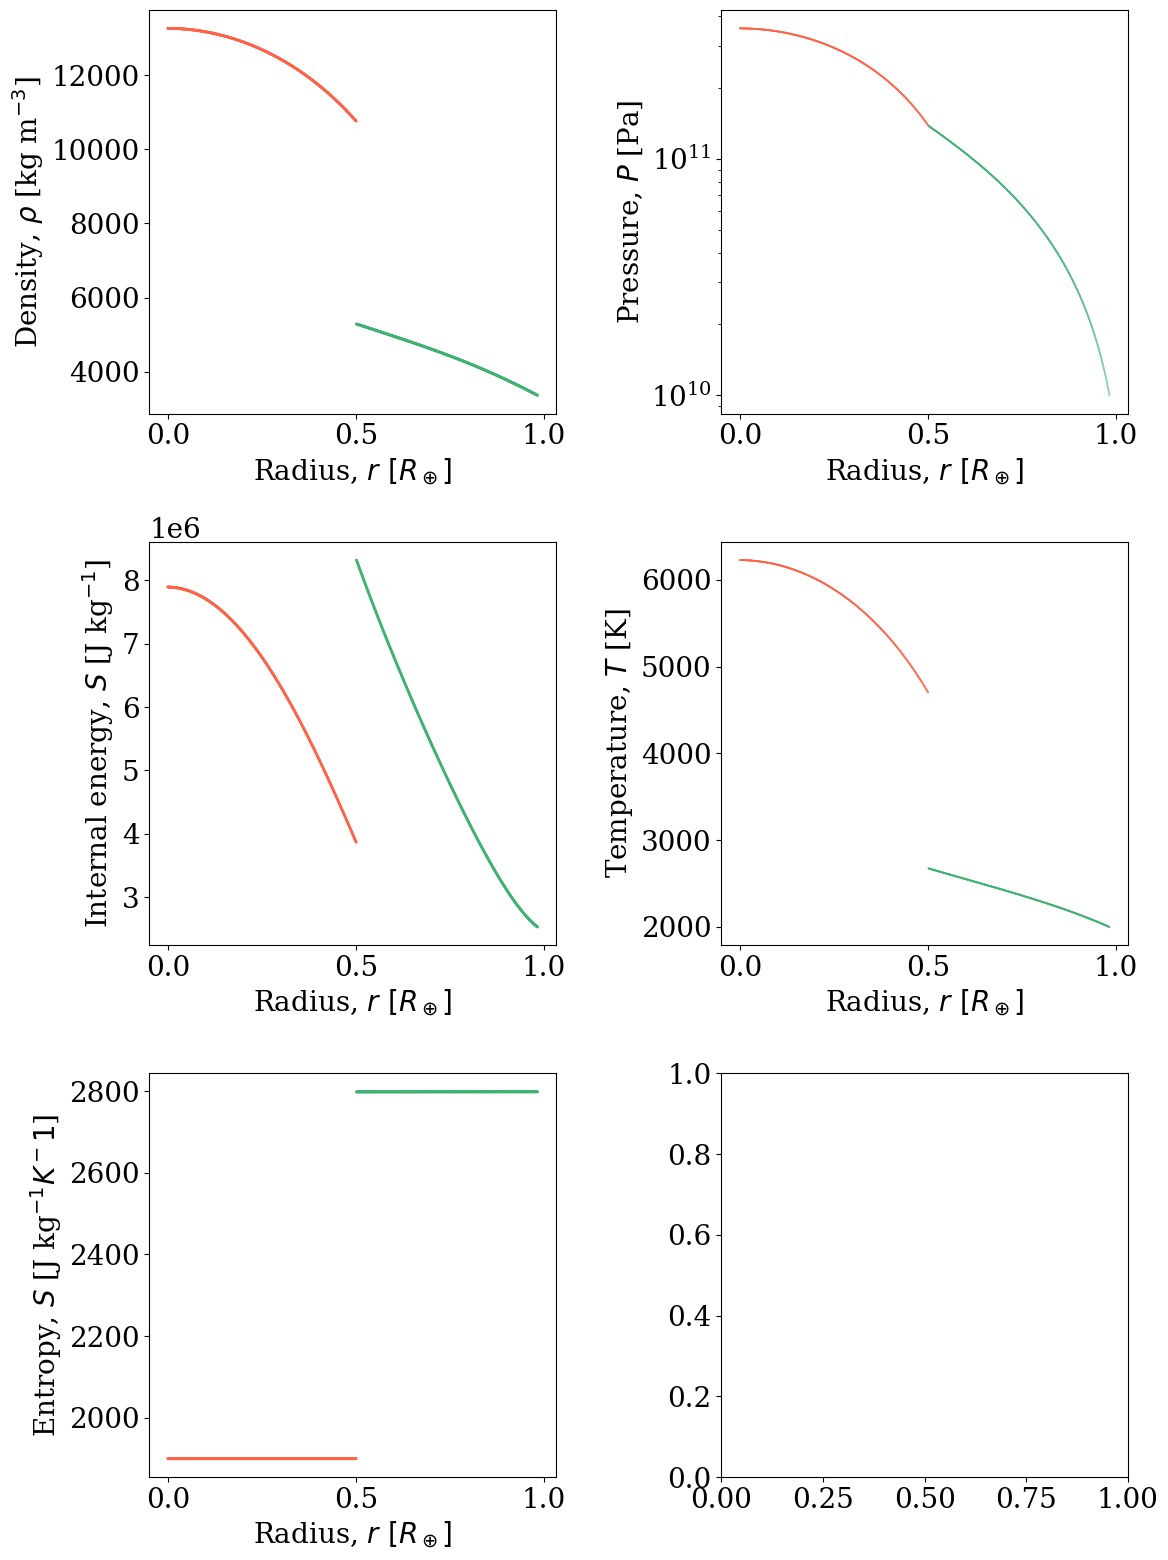

In [12]:
plot_spherical_profiles(
    planet,
    entropy=True,
)

In [ ]:
planet_particles = woma.ParticlePlanet(
    planet, 3e5, verbosity=1
)  # This will place 3e5 particles based on the profile generated at last step.
# Note the final total number of particles can not be controled and this is
# caused by their tuning method of WOMA.

In [ ]:
# Save to the hdf5 file
savepath = "/Users/foo/"
filename = savepath + "planet_npt308510_0d99804Earth.hdf5"
planet_particles.save(
    filename=filename,
    boxsize=10 * R_earth,  # set the boxsize
    file_to_SI=woma.Conversions(
        M_earth, R_earth, 1
    ),  # This will use the earth radius and mass as the storage unit
    # file_to_SI=utils.SI_to_cgs,                                 # You can convert to cgs unit using this command instead
    do_entropies=True,
)  # If you want to use entropy forcing, make sure "do_entropies" is set to True.

Could not find gas gamma, assuming 5./3.
Read 51594 particles!
Could not find gas gamma, assuming 5./3.


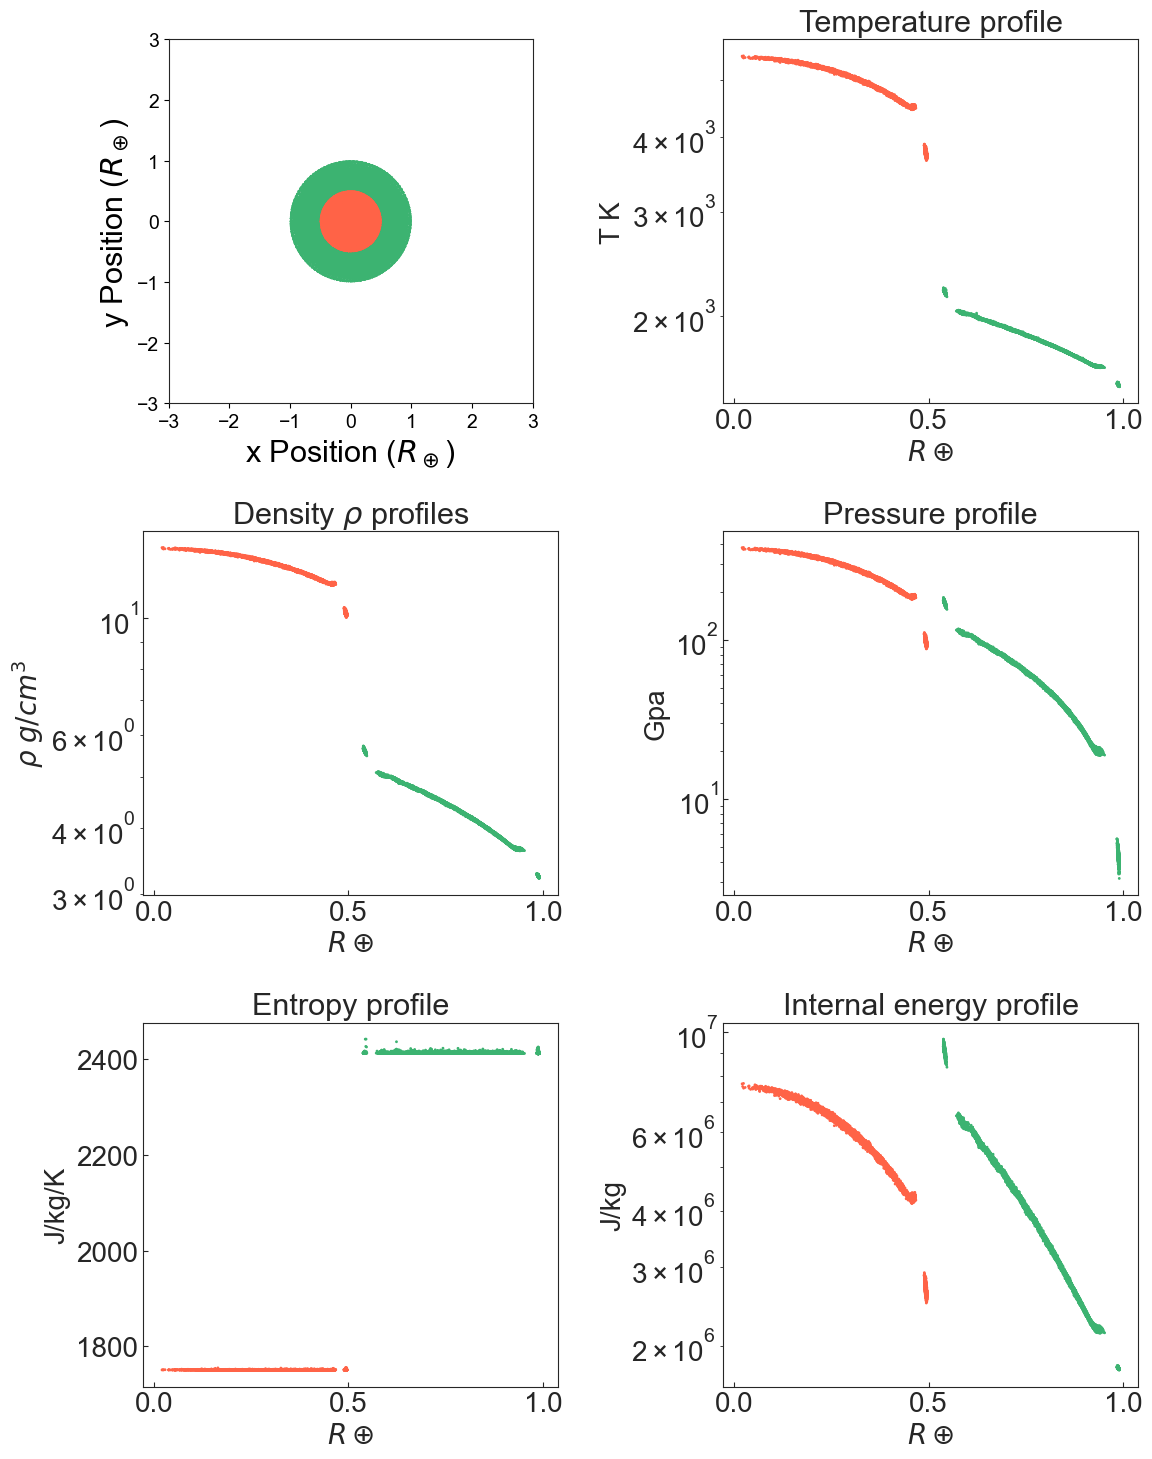

<Figure size 1000x1000 with 0 Axes>

In [52]:
sns.set_style("ticks")
sw_particles_plot("snapOUT_cooling_planet_npt308510_0d99804Earth.hdf5", colourplot=True)

### setup Imapct

You could use the following code to load and generate a complete impact simulation initial condition file.

In [36]:
loc_tar = "snapOUT_cooling_planet_npt308510_0d99804Earth.hdf5"
loc_imp = "snapOUT_cooling_planet_npt308510_0d99804Earth.hdf5"

pos_tar, vel_tar, h_tar, m_tar, rho_tar, p_tar, u_tar, matid_tar, R_tar = load_to_woma(
    loc_tar
)
pos_imp, vel_imp, h_imp, m_imp, rho_imp, p_imp, u_imp, matid_imp, R_imp = load_to_woma(
    loc_imp
)

Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.


In [71]:
M_t = np.sum(m_tar)
M_i = np.sum(m_imp)
R_t = R_tar
R_i = R_imp

# Mutual escape speed

# Initial position and velocity of the target
A1_pos_t = np.array([0.0, 0.0, 0.0])
A1_vel_t = np.array([0.0, 0.0, 0.0])

A1_pos_i, A1_vel_i = woma.impact_pos_vel_b_v_c_t(
    #    b       = np.sin(45 * np.pi/180),
    b=0.7,
    v_c=1.0,
    t=3600,  # seconds
    R_t=R_t,
    R_i=R_i,
    M_t=M_t,
    M_i=M_i,
    units_v_c="v_esc",
)

A1_pos_com = (M_t * A1_pos_t + M_i * A1_pos_i) / (M_t + M_i)
A1_pos_t -= A1_pos_com
A1_pos_i -= A1_pos_com

# Centre of momentum
A1_vel_com = (M_t * A1_vel_t + M_i * A1_vel_i) / (M_t + M_i)
A1_vel_t -= A1_vel_com
A1_vel_i -= A1_vel_com

pos_tar += A1_pos_t
vel_tar[:] += A1_vel_t

pos_imp += A1_pos_i
vel_imp[:] += A1_vel_i
print("Number of particles in target %d" % (len(pos_tar)))

with h5py.File(
    "PLANTimpact_1d0Earth_2d0Earth_npt51594_1d0vesc_0d7b_100box.hdf5", "w"
) as f:
    woma.save_particle_data(
        f,
        np.append(pos_tar, pos_imp, axis=0),
        np.append(vel_tar, vel_imp, axis=0),
        np.append(m_tar, m_imp),
        np.append(h_tar, h_imp),
        np.append(rho_tar, rho_imp),
        np.append(p_tar, p_imp),
        np.append(u_tar, u_imp),
        np.append(matid_tar, matid_imp),
        boxsize=1000 * R_earth,
        file_to_SI=woma.Conversions(M_earth, R_earth, 1),
    )

Number of particles in target 51594

num_particle = 103188
boxsize      = 1e+02
mat_id       = 400 401 

Unit mass    = 5.97240e+27 g
Unit length  = 6.37100e+08 cm
Unit time    = 1.00000e+00 s

Min, max values (file units):
  pos = [46.079, 53.921,    48.835, 51.168,    49.012, 50.987]
  vel = [-0.00048923, 0.00048718,    -0.00019004, 0.00018806,    -7.9704e-06, 9.3737e-06]
  m = 1.9267e-05, 1.9355e-05
  rho = 0.139, 0.58891
  P = 3.3666e-09, 4.0557e-07
  u = 4.3502e-08, 2.38e-07
  h = 0.03951, 0.063961

Saved "PLANTimpact_1d0Earth_2d0Earth_npt51594_1d0vesc_0d7b_100box.hdf5"


### WoMa intial setup double check

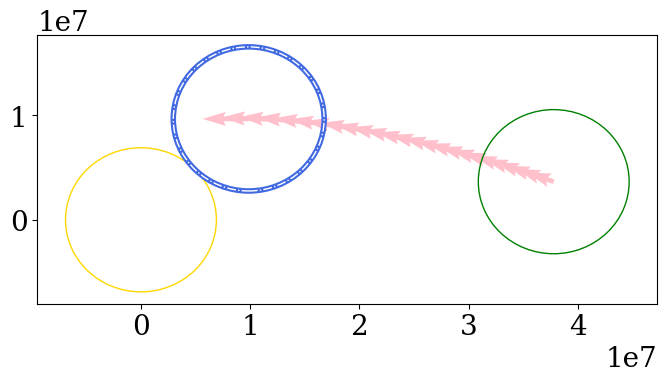

In [39]:
M_t = np.sum(m_tar)
M_i = np.sum(m_imp)
R_t = R_tar
R_i = R_imp
    
times = np.linspace(1e-6,3600,25)
x = np.zeros(len(times))
y = np.zeros(len(times))
vx = np.zeros(len(times))
vy = np.zeros(len(times))

b=0.7
for i in range(len(times)):
    pos, vel  = woma.impact_pos_vel_b_v_c_t(
    b         = b,
    v_c       = 1.0, 
    t         = times[i], 
    R_t       = R_t, 
    R_i       = R_i, 
    M_t       = M_t, 
    M_i       = M_i,
    units_v_c = "v_esc"
)

    x[i]  = pos[0]
    y[i]  = pos[1]
    vx[i] = vel[0]
    vy[i] = vel[1]
    
plt.figure(figsize=(8,3.5))
plt.quiver(x,y,vx,vy,color='pink')
ct=matplotlib.patches.Circle((0,0),radius=R_t,facecolor='none',ec='gold') # target planet
cp=matplotlib.patches.Circle((x[0],y[0]),radius=R_i,facecolor='none',ec='royalblue',lw=4) # impactor [near impact time t=0.00001s] calculated by WoMa
cp0=matplotlib.patches.Circle((x[-1],y[-1]),radius=R_i,facecolor='none',ec='green') # impactor [initial position t= 3600s] calculated by WoMa
cp2=matplotlib.patches.Circle((np.sqrt(1-b**2)*(R_t+R_i),(b)*(R_t+R_i)),radius=R_i,facecolor='none',ec='white',ls='-.') # Theoretical pos of impactor 
plt.gca().add_patch(ct)
plt.gca().add_patch(cp)
plt.gca().add_patch(cp0)
plt.gca().add_patch(cp2)
plt.show()

In [2]:
woma.load_eos_tables(["ANEOS_iron","ANEOS_forsterite"])

In [4]:
loc='/Users/qb20321/Desktop/SWIFTother/Tutorial/snapOUT_cooling_planet_npt51594_0d99893Earth.hdf5'

data    = sw.load(loc)
box_mid = 0.5 * data.metadata.boxsize[0]
pos = data.gas.coordinates - box_mid
data.gas.densities.convert_to_mks()
rho_mks = np.array(data.gas.densities)
data.gas.internal_energies.convert_to_mks()
u_mks   = np.array(data.gas.internal_energies) # internal energy in mks
matid   = np.array(data.gas.material_ids)
m       = np.array(data.gas.masses)

entropy = woma.eos.eos.A1_s_u_rho(u_mks, rho_mks, matid)
T       = woma.eos.eos.A1_T_u_rho(u_mks, rho_mks, matid)


Could not find gas gamma, assuming 5./3.


In [8]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [11]:
MAX

Could not find gas gamma, assuming 5./3.


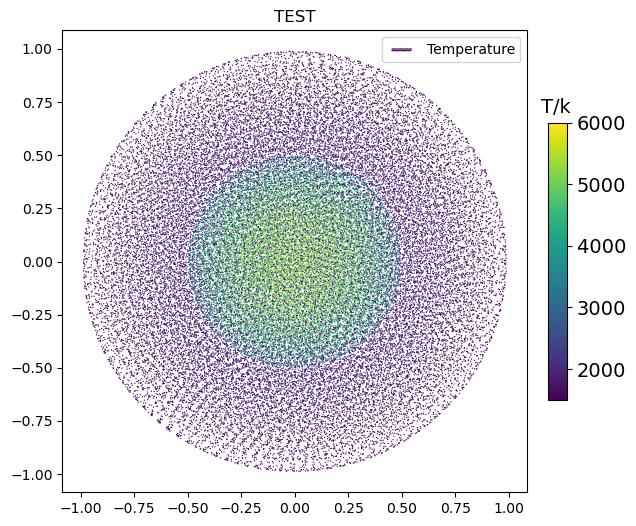

In [26]:
loc='/Users/qb20321/Desktop/SWIFTother/Tutorial/snapOUT_cooling_planet_npt51594_0d99893Earth.hdf5'

data    = sw.load(loc)
box_mid = 0.5 * data.metadata.boxsize[0]
pos = data.gas.coordinates - box_mid
data.gas.densities.convert_to_mks()
rho_mks = np.array(data.gas.densities)
data.gas.internal_energies.convert_to_mks()
u_mks   = np.array(data.gas.internal_energies) # internal energy in mks
matid   = np.array(data.gas.material_ids)
m       = np.array(data.gas.masses)

entropy = woma.eos.eos.A1_s_u_rho(u_mks, rho_mks, matid)
T       = woma.eos.eos.A1_T_u_rho(u_mks, rho_mks, matid)

pos_centerM = np.sum(pos * m[:, np.newaxis], axis=0) / np.sum(m)
pos -= pos_centerM


fig, ax = plt.subplots(1,1,figsize=(6,6))
cimg = ax.scatter(
pos[:, 0],
pos[:, 1],
s=3.5,
c=T,
edgecolors="none",
marker=".",
alpha=1,
cmap='viridis',
label='Temperature',
vmin = 1500,
vmax = 6000,

)
MAX = np.max(T)

cbaxes = inset_axes(ax,width="4%", height="60%",loc='right',bbox_to_anchor=(0.1,0,1,1),bbox_transform=ax.transAxes) 
cbar = fig.colorbar(cimg, ax=ax, cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 12.5
cbar.ax.tick_params(labelsize=14,color='k')
cbar.outline.set_edgecolor('k')
cbar.ax.yaxis.set_ticks_position('right')
ax.text(1.15,0.7,r'T/k',fontsize=14)

ax.set_title("TEST")
ax.legend(scatterpoints=50)

plt.show()
plt.cla()
fig.clf() 
plt.close()



Could not find gas gamma, assuming 5./3.


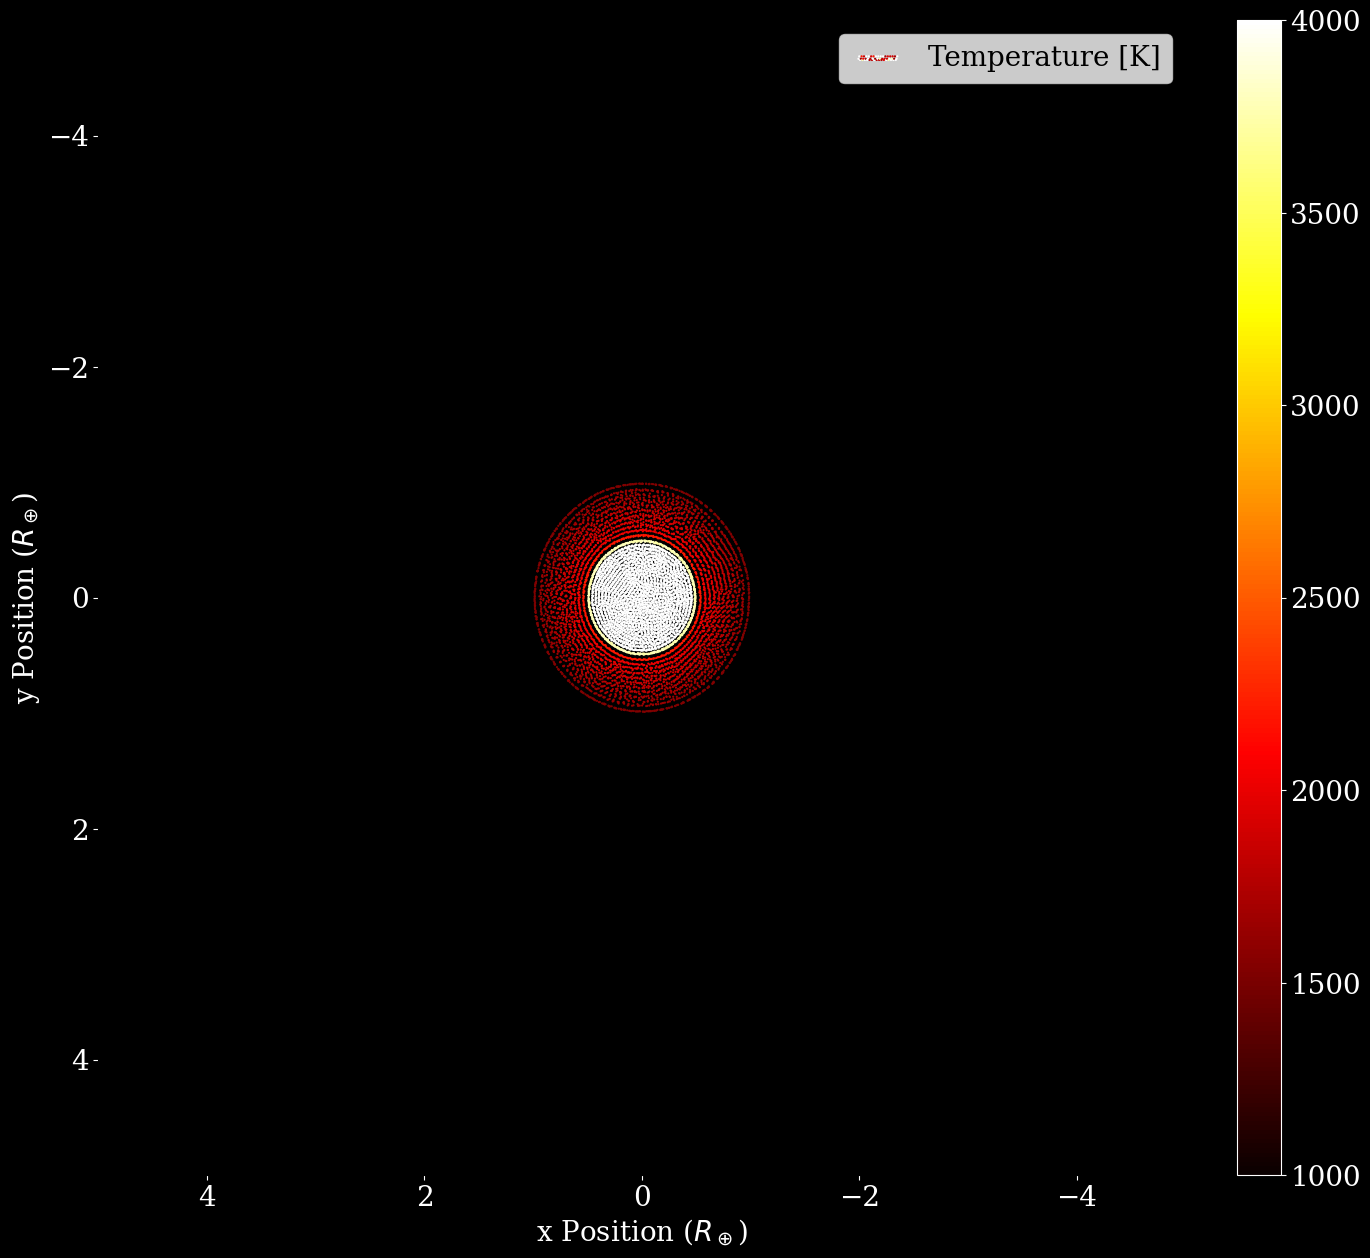

In [35]:
#!/usr/bin/env python
import woma
import swiftsimio as sw
import numpy as np
import unyt
import h5py
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from woma.misc import utils
from copy import copy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
#import pylustrator
#pylustrator.start()

woma.load_eos_tables() # load the eos table for the calculation of entropy at later stage
loc='/Users/qb20321/Desktop/SWIFTother/Tutorial/snapOUT_cooling_planet_npt51594_0d99893Earth.hdf5'

#snapshotfile = "example_%04d.hdf5"%i
data    = sw.load(loc)
box_mid = 0.5 * data.metadata.boxsize[0].to(unyt.Rearth)
pos = data.gas.coordinates.to(unyt.Rearth) - box_mid
data.gas.densities.convert_to_mks()
rho_mks = np.array(data.gas.densities)
data.gas.internal_energies.convert_to_mks()
u_mks   = np.array(data.gas.internal_energies) # internal energy in mks
matid   = np.array(data.gas.material_ids)
data.gas.masses.convert_to_mks()
m       = np.array(data.gas.masses)
m = data.gas.masses
ax_lim = 5
x_min = box_mid - ax_lim * unyt.Rearth
x_max = box_mid + ax_lim * unyt.Rearth
load_region = [[x_min, x_max], [x_min, x_max], [x_min, box_mid]]
data.gas.pressures.convert_to_cgs()
p = np.array(data.gas.pressures)
entropy = woma.eos.eos.A1_s_u_rho(u_mks, rho_mks, matid)
T       = woma.eos.eos.A1_T_u_rho(u_mks, rho_mks, matid)


pos_centerM = np.sum(pos * m[:, np.newaxis], axis=0) / np.sum(m)
pos -= pos_centerM



#box_mid = 0.5 * data.metadata.boxsize[0]
#pos = data.gas.coordinates - box_mid
id = data.gas.particle_ids
#mat_id = data.gas.material_ids.value


#idoff = 200000000
#bodyoff = 100000000

# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
sel = np.where(pos[:, 2] < .01)[0]  # half planet below with z<0                         #$
sel = np.where(np.logical_and(pos[:, 2] < .1,pos[:, 2] > -.1))[0]  #Thin slice cut       #$
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

matid = matid[sel]
id = id[sel]
m = m[sel]
T = T[sel]
pos = pos[sel]

# Sort in z order so higher particles are plotted on top
sort = np.argsort(pos[:, 2])
matid = matid[sort]
id = id[sort]
m = m[sort]
T = T[sort]
pos = pos[sort]



font_size = 20
params = {
"axes.labelsize": font_size,
"font.size": font_size,
"xtick.labelsize": font_size,
"ytick.labelsize": font_size,
"font.family": "serif",
}
matplotlib.rcParams.update(params)

# Material IDs ( = type_id * type_factor + unit_id )
type_factor = 100
type_idg = 0
type_Til = 1
type_HHe = 2
type_SESAME = 3
type_ANEOS = 4
id_body = 1000000
outtime   =100  #insert time in seconds of each snapshot output
txtsize   =15
font_size = 20

# Name and ID
Di_mat_id = {
"ANEOS_iron": type_ANEOS * type_factor + 1,
"ANEOS_iron_2": type_ANEOS * type_factor + 1 + id_body,
"ANEOS_forsterite": type_ANEOS * type_factor,
"ANEOS_forsterite_2": type_ANEOS * type_factor + id_body,
}

Tmax = 4000
Tmin = 1000


fig, ax = plt.subplots(1,1,figsize=(15,15))
cimg = ax.scatter(
pos[:, 0],
pos[:, 1],
s=10,
c=T,
edgecolors="none",
marker=".",
alpha=1,
cmap='hot',
label='Temperature [K]',
vmax = Tmax,
vmin = Tmin,


)
MAX = Tmax

cbaxes = inset_axes(ax,width="4%", height="100%",loc='right',bbox_to_anchor=(0.1,0,1,1),bbox_transform=ax.transAxes)
cbar = fig.colorbar(cimg, ax=ax, cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 12.5
cbar.ax.tick_params(labelsize=20, colors='w') #Size of label's numbers
cbar.outline.set_edgecolor('w')
cbar.ax.yaxis.set_ticks_position('right')


ax.set_xlim(-ax_lim, ax_lim)
ax.set_xlim(ax_lim, -ax_lim)
ax.set_yticks(ax.get_xticks())
ax.set_ylim(ax_lim, -ax_lim)
ax.set_xlabel(r"x Position ($R_\oplus$)")
ax.set_ylabel(r"y Position ($R_\oplus$)")
ax.set_facecolor("black")
fig.patch.set_facecolor('black')
ax.legend(scatterpoints=50)
plt.subplots_adjust(right=0.85)


ax.yaxis.label.set_color('w')
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w',labelsize=20)
ax.tick_params(axis='y', colors='w',labelsize=20)







plt.show()
plt.cla()
fig.clf()
plt.close()


In [ ]:
from celluloid import Camera
from IPython.display import HTML

fig,ax = plt.subplots(1,1,figsize=(6,6))
camera = Camera(fig)

snapdir = '/user/home/qb20321/hammer/denseplanets/Gj367/EiEf/impact/pX/b0d00/v38d2kms/smalldt/output_10h_100dt/'
for i in range(37,40):
    snapshotfile = snapdir+"snapshot_%04d.hdf5"%i
    data    = sw.load(snapshotfile)
    box_mid = 0.5 * data.metadata.boxsize[0]
    pos = data.gas.coordinates - box_mid
    data.gas.densities.convert_to_cgs()
    rho = np.array(data.gas.densities)
    matid   = np.array(data.gas.material_ids)
    
    sel_core = matid==400
    sel_mantle = matid==401

    core_r   = np.hypot(pos[sel_core,2],np.hypot(pos[sel_core,0], pos[sel_core,1]))
    mantle_r = np.hypot(pos[sel_mantle,2],np.hypot(pos[sel_mantle,0], pos[sel_mantle,1]))
    
    core_rho   = rho[sel_core]
    mantle_rho = rho[sel_mantle]
    
    c = ax.scatter(core_r,core_rho,c='gold',label='core',s=0.1)
    m = ax.scatter(mantle_r,mantle_rho,c='mediumseagreen',label='mantle',s=0.1)
    
    ax.set_xlabel(r'$R_{\oplus}$')
    ax.set_ylabel(r'$\rho$ $g.cm^{-3}$')
    
    ax.legend([c,m],['core','mantle'],scatterpoints=50,loc='lower left')
    ax.text(0.97,0.97,r'{0:6.2f} h'.format(i*100/3600), # change 100 to your output frequency in second
              transform=ax.transAxes,ha='right',va='top',fontsize=18,color='w',fontweight='bold')
    
    camera.snap()
    

animation = camera.animate(interval=500, blit=True) # change to less 'interval' value to increase fps
HTML(animation.to_html5_video()) # show in jupyter notebook
# animation.save(
#     'rho_R.mp4',
#     dpi=100,
#     savefig_kwargs={
#         'frameon': False,
#         'pad_inches': 'tight'
#     }
# )


[Back to Contents](#top)